# Plots for my PhD Thesis

All those plots come from my different researches. The intention is to have them coherently designed.

### Required packages and Constants

In [6]:
using HDF5

In [1]:
using PyPlot

L_FSIZE = 16
T_FSIZE = 14
CMAP = "viridis"
CMAP_R = "viridis_r"
HG = 3.5 #inches
WD = 5 #inches
LWD = 1.5 #points

1.5

## Plot for accuracy bound in the vicinity of Dicke states

Those plots come from an analytical formula so the data is generated on the fly.

The magnetic field is along $Y$ direction, $H=\gamma J_y$

In [3]:
# It is a function of 5 expectation values <Jx^2>, <Jz^2>, <Jx^4>, <Jz^4> and <JzJx^2Jz>, and θ.
function precision(x2,z2,x4,z4,zx2z,θ)
    variancex2 = x4 - x2^2
    variancez2 = z4 - z2^2
    ftheta = variancez2 / (variancex2 * tan(θ)^2) + tan(θ)^2
    (variancex2 * ftheta + x2 - 2 * z2 * (1 + x2) + 6 * zx2z) / (4 * (x2 - z2)^2)
end

function opttheta(x2,z2,x4,z4)
    variancex2 = x4 - x2^2
    variancez2 = z4 - z2^2
    atan((variancez2 / variancex2)^0.25)
end

precision2(x2,z2,x4,z4,n,θ) = precision(x2,z2,x4,z4,(n*(n+2)/8*z2-z4/2),θ)

optprecision(x2,z2,x4,z4,zx2z) = precision(x2,z2,x4,z4,zx2z,opttheta(x2,z2,x4,z4))

optprecision2(x2,z2,x4,z4,n) = optprecision(x2,z2,x4,z4,(n*(n+2)/8*z2-z4/2))

optprecision3(x2,z2,n) = optprecision2(x2, z2, n^2/4 * x2, 3 * z2^2, n)

optprecision3 (generic function with 1 method)

### Vectorize functions for computing the data

In [4]:
function precision(x2,z2,x4,z4,zx2z,θ::Array{Float64,1})
    outcome = Array(Float64, length(θ))
    for i in 1:length(θ)
        outcome[i] = precision(x2,z2,x4,z4,zx2z,θ[i])
    end
    outcome
end

optprecision3(x2::Array{Float64,1},z2::Array{Float64,1},n) = begin
    outcome = Array(Float64,length(x2),length(z2))
    for i in 1:length(x2)
        for j in 1:length(z2)
            outcome[i,j] = optprecision3(x2[i],z2[j],n)
        end
    end
    outcome
end

optprecision3 (generic function with 2 methods)

### Plot evolution

In [5]:
# Data
xmax=0.03
x = Array(linspace(0,xmax,200));
y = precision2(6e6, 112, 6.2e13, 4e4, 7900, x).^(-1)./7900;

Save the data

In [7]:
h5write("data/data.h5", "VD_precision_theta/y", y)

In [8]:
file = h5open("data/data.h5")

HDF5 data file: data/data.h5

In [ ]:
file["VD_precision_theta"]

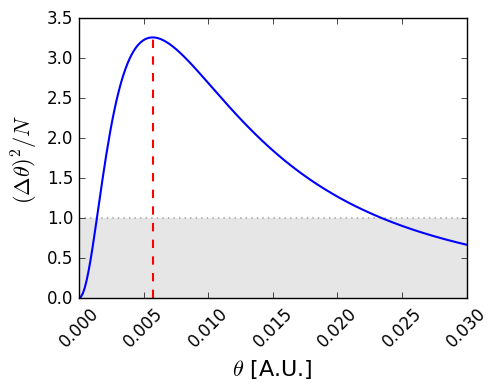

In [204]:
# maximum line
indx = indmax(y)

# Figure
fig = figure(figsize=(5,3.5))
xl = xlabel(L"$\theta$ [A.U.]", fontsize=L_FSIZE)
yl = ylabel(L"$(\Delta \theta)^2/N$", fontsize=L_FSIZE)
xticks(rotation=45)

ax = axis(xmin=0, xmax=xmax)

# SN thresold
bar(0,1,0.03,0, color="0.9", edgecolor="0.7",linewidth=0)
plot([0,0.03],[1,1], color="0.7", linewidth=LWD, linestyle="dotted")

plot([x[indx],x[indx]],[0,y[indx]], "--r", linewidth=LWD)
plt = plot(x,y,linewidth=LWD)


savefig("svg/VD_precision_theta.svg", bbox_inches="tight")

### Plot versus QFI of known states

### Plot contour

In [206]:
n = 7900
points = 500
x = Array(linspace(0,n*(n+2)/8,points))/(n*(n+2)/8)
y = Array(linspace(0,400,points))
z = (optprecision3(x*n*(n+2)/8,y,7900).^(-1)/n)'
z[1:end,1] = zeros(1,points)
ln = 15
map!(x -> if x > ln || isnan(x) 15 else x end,z);

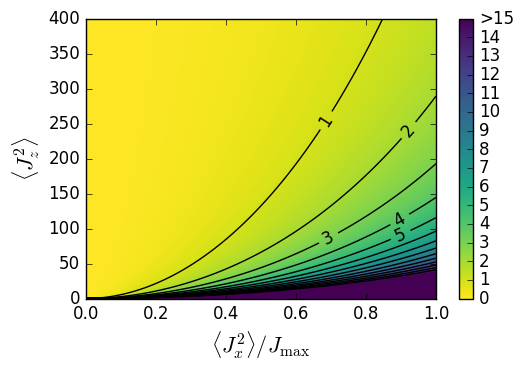

In [207]:
fig = figure(figsize=(6,3.5))

ylabel(L"$\langle J_z^2\rangle$", fontsize=L_FSIZE)
xlabel(L"$\langle J_x^2\rangle / J_{\rm max}$", fontsize=L_FSIZE)

im = imshow(z, cmap="viridis_r", interpolation="bilinear",
origin="lower", extent=[0,1,0,400], aspect=1/400*4/5)

c = contour(x,y,z,ln-1,colors="k")
clabel(c, fmt="%1.0f", manual=[(0.7,250),(0.9,250),(0.7,80),(0.9,110),(0.9,90)])
cb = colorbar(im, ticks=Array(0:ln))
cb[:ax][:set_yticklabels](vcat(map(string, Array(0:ln-1)),">$ln"))

savefig("svg/VD_contour.svg", bbox_inches="tight")

## Plots for the legendre transform.

Get image for the spin-squeezing bound from blender(c), still it is not possible to do this on matplotlib. This is because the smoothness needed at the border. Image file `data/LT_spsq2d_4.png`.

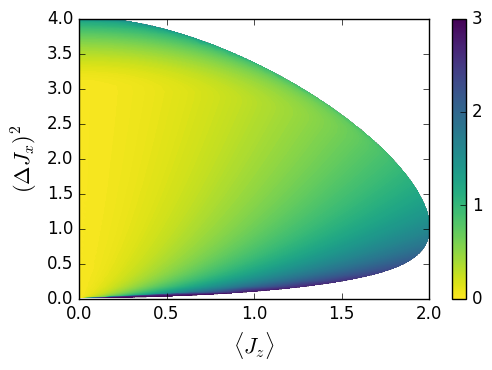

In [210]:
figure(figsize=(6,3.5))

xlabel(L"\langle J_z \rangle",fontsize=L_FSIZE)
ylabel(L"(\Delta J_x)^2",fontsize=L_FSIZE)

png = imread("data/data-spsq-4-blender.png")
data = (png[:,:,1]+png[:,:,2]+png[:,:,3])/3
# deal with the alpha chanel
achanel = png[:,:,4]
map!((x)->if x==0 NaN else 0 end,achanel)
data = data+achanel
data = (data - minimum(data))/(maximum(data)-minimum(data))

im = imshow(data, cmap=CMAP_R ,aspect=1/2*4/5, extent=[0,2,0,4])
t_line = plot()

cb = colorbar(im, ticks=Array(linspace(0,1,4)))
cb[:ax][:set_yticklabels](vcat(map(string, Array(0:3)),">$ln"))

savefig("svg/LT_spsq2d_4.svg", bbox_inches="tight")

LoadError: LoadError: UndefVarError: @manipulate not defined
while loading In[211], in expression starting on line 1